In [118]:
import pandas as pd, numpy as np
import os, json
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torch_data
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
os.chdir('/home/users/arash/NGA Project/POI_paper/busyness_graph/')
os.getcwd()
from data_loader.forecast_dataloader import ForecastDataset
pd.set_option('display.max_columns', 50)


In [2]:
TRAIN_RATIO = 0.7
VALID_RATIO = 0.2
TEST_RATIO = 1 - (TRAIN_RATIO + VALID_RATIO)

WINDOW_SIZE = 24
HORIZON = 6
NORM_METHOD = 'z_score'
DATASET = 'Houston'
START_POI = 0
END_POI = 400
BATCH_SIZE = 1

CAT_COLS = ['top_category', 'sub_category']

RESULT_TRAIN_FILE = f'output/{DATASET}/train_{START_POI}_{END_POI}'

In [3]:
df = pd.read_pickle('cache_data/data-0-400-400.pkl')

data = pd.DataFrame(df["visits_by_each_hour"].to_list()).T

# split data
days = int(data.shape[0] / 24)

train_days = int(TRAIN_RATIO * days)
valid_days = int(days*VALID_RATIO)
test_days = days-train_days-valid_days

train_data = data[:train_days*24]
valid_data = data[train_days*24:(train_days + valid_days)*24]
test_data = data[(train_days + valid_days)*24:(train_days + valid_days+test_days)*24]

with open(os.path.join(RESULT_TRAIN_FILE, 'norm_stat.json'),'r') as f:
    normalize_statistic = json.load(f)


test_set = ForecastDataset(test_data, window_size=WINDOW_SIZE, 
                            horizon=HORIZON,
                            normalize_method=NORM_METHOD, 
                            norm_statistic=normalize_statistic,
                            df_static_features=df[CAT_COLS])

test_loader = torch_data.DataLoader(test_set, batch_size=BATCH_SIZE, drop_last=False,
                                    shuffle=False, num_workers=0)

model = torch.load('output/Houston/train_0_400/39_stemgnn.pt')

In [4]:
df.head(3)

,safegraph_place_id,visits_by_day,visits_by_each_hour,raw_visit_counts,location_name,street_address,city,region,postal_code,iso_country_code,...,brands,parent_safegraph_place_id,top_category,sub_category,naics_code,latitude,longitude,phone_number,open_hours,category_tags
0,sg:4cc165ff43ec4ce29e9dbe0732267ab1,"[6140, 6399, 6752, 7324, 7255, 5874, 7496, 700...","[83, 49, 41, 60, 187, 301, 161, 151, 257, 112,...",3574654,George Bush Intercontinental Airport,2800 N Terminal Rd,Houston,TX,77032.0,US,...,NaN,NaN,Support Activities for Air Transportation,Other Airport Operations,488119.0,29.981382,-95.322839,NaN,NaN,NaN
1,sg:e8af4e248bbf41549aaec725d038ee42,"[2553, 2568, 2729, 2939, 2940, 2541, 3215, 290...","[21, 23, 21, 14, 52, 108, 53, 56, 130, 38, 119...",1427339,American Express Centurion Lounge,2800 N Terminal Rd Terminal D,Houston,TX,77032.0,US,...,NaN,sg:f4a955def8ca49fd87153af82a237245,Gasoline Stations,Gasoline Stations with Convenience Stores,447110.0,29.987829,-95.334916,NaN,"{ ""Mon"": [[""5:30"", ""21:00""]], ""Tue"": [[""5:30"",...",NaN
2,sg:01cebfb757224fbd8151ee6ac6b0d679,"[2122, 2538, 2558, 2641, 2911, 3741, 2484, 245...","[6, 5, 12, 4, 7, 20, 31, 40, 50, 58, 64, 97, 8...",1357595,Simon mall,5085 Westheimer Rd,Houston,TX,77056.0,US,...,Simon mall,NaN,Lessors of Real Estate,Malls,531120.0,29.738954,-95.463803,NaN,"{ ""Mon"": [[""10:00"", ""19:00""]], ""Tue"": [[""10:00...",NaN


In [12]:
(inputs, target, static_features) = next(iter(test_loader))
model.eval()
with torch.no_grad():
    forecast_result, attention_scores = model(inputs, static_features)
    attention_scores = attention_scores.squeeze(0).cpu().numpy()

In [75]:
df['raw_visit_counts'] = df['raw_visit_counts'].astype('int')
df = df.reset_index()
row_numbers = df['index']
def plot_map(df, save=False, file_name='fig1.png', metric='mape', max_size=15):
    fig = px.scatter_mapbox(df, lat="latitude", lon="longitude",
                            hover_name="location_name", 
                            hover_data=["index", "raw_visit_counts", "street_address",
                                        'top_category', 'sub_category'],
                            color='raw_visit_counts', 
                            size='raw_visit_counts',
                            zoom=9.5,
                            size_max=max_size,
                            opacity=0.5,
                            height=700,
                            width = 1000
    )
    colorbar=dict(len=.75,
                    title=metric)
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.update_layout(coloraxis_colorbar=colorbar)
    fig.show()
    if save:
        fig.write_image(file_name, scale=3)

In [127]:
# target_pois = [34, 72, 26, 69, 98, 135, 285]
target_pois = [26, 285, 69, 34, 135, 28, 98]
target_cats = [410, 438, 421, 420]
plot_map(df.iloc[target_pois], max_size=20)

<AxesSubplot: >

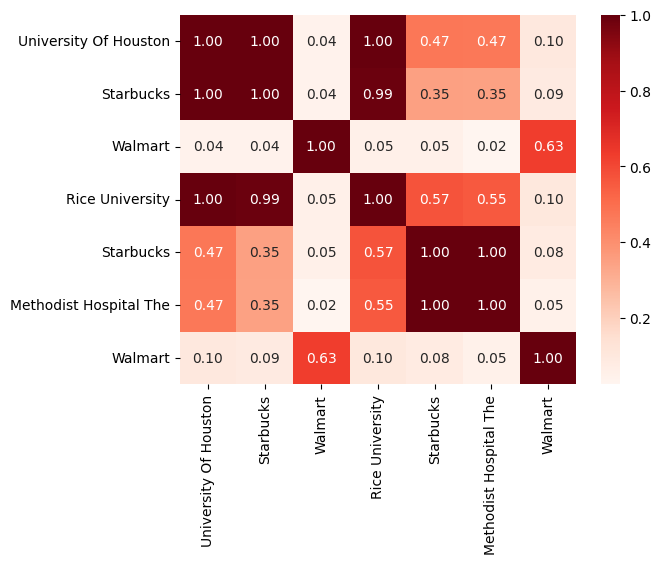

In [151]:
target_poi_attentions = attention_scores[np.ix_(target_pois, target_pois)]
target_labels = df.iloc[target_pois].location_name
sns.heatmap(target_poi_attentions, annot=True, fmt='.2f', annot_kws={'size': 10}, cmap='Reds',
            xticklabels=target_labels, yticklabels=target_labels)

<AxesSubplot: >

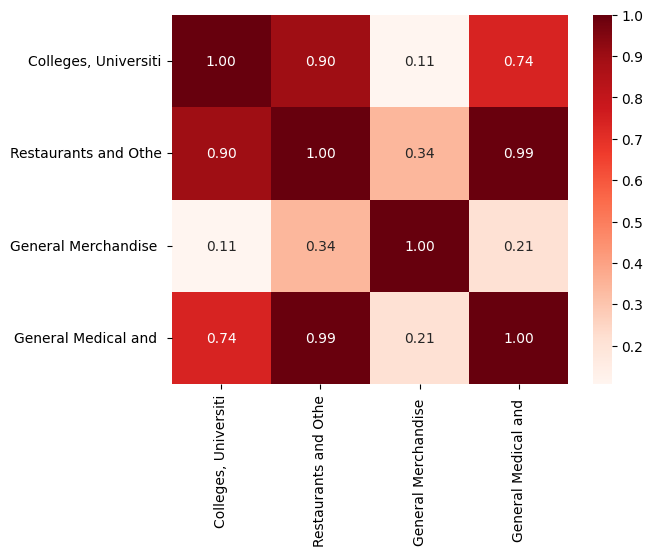

In [152]:
target_poi_cats = attention_scores[np.ix_(target_cats, target_cats)]
target_cat_labels = df.iloc[target_cats].top_category.str[:20]
sns.heatmap(target_poi_cats, annot=True, fmt='.2f', annot_kws={'size': 10}, cmap='Reds',
            xticklabels=target_cat_labels, yticklabels=target_cat_labels)

<AxesSubplot: >

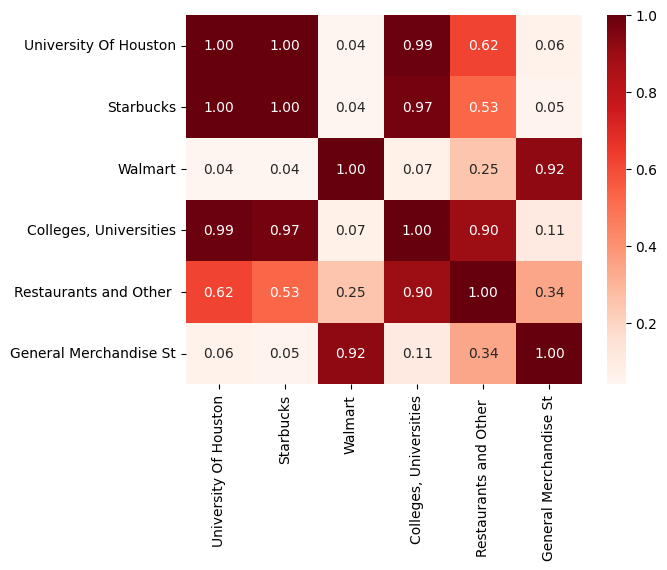

In [153]:
all_together = [26, 285, 69, 410, 438, 421]
all_attention = attention_scores[np.ix_(all_together, all_together)]
all_labels = list(df.iloc[[26, 285, 69]].location_name) + list(df.iloc[[410, 438, 421]].top_category.str[:22])
sns.heatmap(all_attention, annot=True, fmt='.2f', annot_kws={'size': 10}, cmap='Reds',
            xticklabels=all_labels, yticklabels=all_labels)

In [260]:
def plot_timeseries(true_ts, forecast_ts, labels):
    plt.style.use('seaborn')
    fig, ax = plt.subplots(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.title('Normalized True Visits')
    plt.plot(true_ts, label=labels)
    plt.legend()
    # fig, ax = plt.subplots(figsize=(8, 4))
    plt.subplot(1, 2, 2)
    plt.plot(forecast_ts, label=labels)
    plt.title('Normalized Forecasted Visits')
    plt.legend()


/tmp/ipykernel_6272/3662615002.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

/tmp/ipykernel_6272/3662615002.py:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



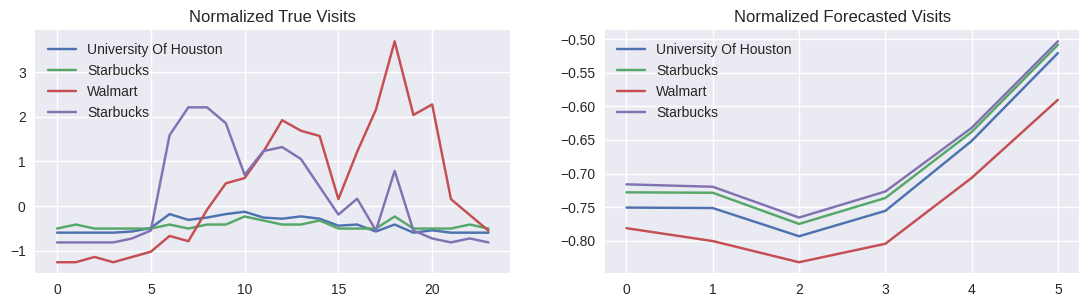

In [261]:
poi_plot_ids = [26, 285, 69, 135]
poi_plot_labels = df.iloc[poi_plot_ids].location_name
poi_true_ts = inputs[0, :, poi_plot_ids]
poi_forecast_ts = forecast_result.cpu()[0, :, poi_plot_ids]
plot_timeseries(poi_true_ts, poi_forecast_ts, poi_plot_labels)

/tmp/ipykernel_6272/3662615002.py:2: MatplotlibDeprecationWarning:

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.

/tmp/ipykernel_6272/3662615002.py:4: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



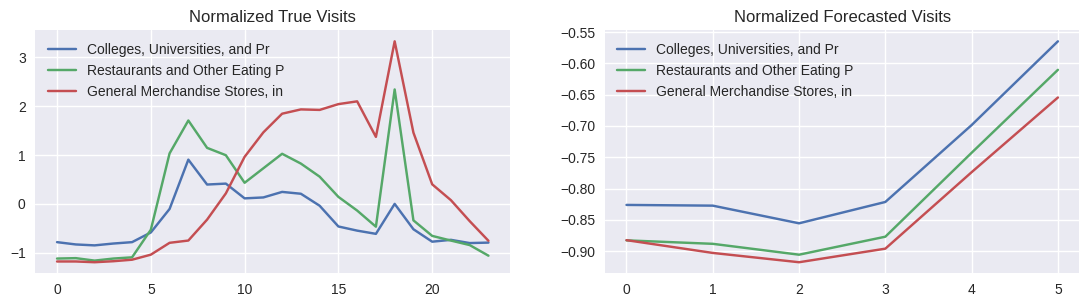

In [262]:
cat_plot_ids = [410, 438, 421]
cat_plot_labels = df.iloc[cat_plot_ids].top_category.str[:30]
cat_true_ts = inputs[0, :, cat_plot_ids]
cat_forecast_ts = forecast_result.cpu()[0, :, cat_plot_ids]
plot_timeseries(cat_true_ts, cat_forecast_ts, cat_plot_labels)